In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Read in the data from the CSV file and check the output.

In [2]:
#Read in CSV file
df = pd.read_csv('raw_data/PO_Dataset.csv')

#Print some records
df.head()


,Company #,Purchase Order,Item,Vendor,Description,Unit of Measure,Units,Unit Cost,Cost,Cost Code
0,8,1200-001,1,Paragon Electrical Installations Ltd.,Additional smoke detector/re-verification,LS,0,0.0,1444.0,26-20-20
1,8,1200-002,1,Accurate Aluminum Ltd,S&I railing as per quote Aug. 13 2015,LS,0,0.0,500.0,05-52-20
2,8,1200-003,1,Dura Productions,S&I metal ramp,LS,0,0.0,795.0,05-52-20
3,8,1200-004,1,Friesen Floors & Window Fashions Ltd,S&I hardwood flooring for enclosed balcony area,LS,0,0.0,2314.0,09-64-33
4,8,1209-1-01,1,Alba Painting Ltd.,Painting of two offices,LS,0,0.0,900.0,09-91-40


In [3]:
#Check how much data was loaded
print('File Contains Columns:{} Rows:{}'.format(df.shape[1], df.shape[0]))

File Contains Columns:10 Rows:39414


## Start cleaning the data

In [4]:
#What are the column types?
df.dtypes

Company #            int64
Purchase Order      object
Item                 int64
Vendor              object
Description         object
Unit of Measure     object
Units               object
Unit Cost          float64
Cost               float64
Cost Code           object
dtype: object

The Units column should be a float. It may be relevant to the prediction of cost type to know how many units of a product have been purchased.


In [5]:

#The Convert the Units column to float
df['Units'] = pd.to_numeric(df['Units'], errors='coerce').fillna(0)
df['Units'] = df['Units'].astype('float64')

#Confirm change
df.dtypes

Company #            int64
Purchase Order      object
Item                 int64
Vendor              object
Description         object
Unit of Measure     object
Units              float64
Unit Cost          float64
Cost               float64
Cost Code           object
dtype: object

In [7]:
#How many unique cost codes do we see in the dataset?
print('{} unique cost codes in raw dataset'.format(df['Cost Code'].nunique()))

#Are all the cost codes formatted correctly and valid?
#Read in CSV file master list of cost codes
df_ml = pd.read_csv('raw_data/Code_Master_list.csv')
print('There are {} cost codes in the master list'.format(df_ml['Cost Code'].count()))

#Drop rows where the cost code is not in the master list
df = df[df['Cost Code'].isin(df_ml['Cost Code'])].dropna()


print('{} unique cost codes in dataset after cleaning'.format(df['Cost Code'].nunique()))
df['Cost Code'].unique()

375 unique cost codes in raw dataset
There are 905 cost codes in the master list
354 unique cost codes in dataset after cleaning


array(['26-20-20', '05-52-20', '09-64-33', '09-91-40', '09-21-17',
       '26-20-13', '26-60-10', '08-41-26', '08-11-13', '08-71-11',
       '10-21-13', '10-26-13', '10-28-14', '10-28-15', '08-83-13',
       '06-46-23', '01-52-19', '05-70-10', '06-10-80', '01-52-23',
       '03-80-11', '22-10-20', '01-58-13', '01-51-23', '21-10-14',
       '01-52-25', '01-74-13', '01-52-17', '08-43-26', '10-41-10',
       '09-30-60', '23-50-20', '05-50-10', '08-43-13', '07-32-10',
       '07-62-10', '07-71-23', '07-14-13', '08-63-10', '08-41-13',
       '02-41-13', '01-54-16', '06-10-63', '04-22-10', '32-31-13',
       '01-33-23', '03-80-10', '08-33-23', '07-81-10', '09-97-10',
       '03-35-10', '09-65-16', '26-80-10', '01-52-22', '10-14-70',
       '05-52-24', '06-22-10', '03-31-46', '05-10-10', '08-14-43',
       '01-52-16', '06-10-82', '08-34-80', '02-24-13', '28-10-13',
       '22-40-20', '31-45-21', '31-23-17', '31-11-10', '31-23-25',
       '31-22-13', '03-90-10', '01-56-26', '06-10-60', '06-10-

## Analysis of Cost Code usage

From the cell above, we know that of 905 cost codes in the master list, only 354 have been used in this dataset.
This could mean two things. 
- We do not have a complete dataset and the accuracy of the model will suffer for this.
- Or the codes that are not represented by purchase orders are not relevant to the types of costs that are incurred by purchase orders. For example, cost code 00-10-11 - Architectural Consultant. An Architectural Consultant's services would be secured using a contract, not a purchase order. While the cost is still accrued to the job, it is not recorded through a purchase order therefore no purchase orders exist using this code.

Since the dataset is several years old and encompasses many projects and in addition to the reasoning explained in the example, I would lean towards the second point; that some cost codes are not relevant to purchase orders. So based on that decision, I will drop the unused codes from the output of the predictive model. This will decrease the number of output variables of the model from 905 to 354.

In [9]:
df_ml_clean = df_ml[df_ml['Cost Code'].isin(df['Cost Code'])].dropna()

print(df_ml_clean)
df_ml_clean.to_csv(r'clean_data/Clean_Code_Master_list.csv',index=False)

    Cost Code                            Description
7    00-10-17                geotechnical consultant
26   00-61-13                         subtrade bonds
34   01-30-12                        project manager
36   01-30-14                    project coordinator
45   01-30-23               finishing superintendent
52   01-30-30                                foreman
53   01-30-31                             flagperson
55   01-30-33                               labourer
56   01-30-40                         safety manager
57   01-30-41                                    cso
58   01-30-42                    first aid attendent
60   01-30-51                  deficiency technician
65   01-31-40                                cartage
66   01-32-33             photographic documentation
67   01-32-50                           bim modeling
68   01-33-23          submittal printing & drafting
69   01-45-41                scaffolding engineering
70   01-45-42                      crane engin

Average # of times a code is used: 111.03
Median # of times a code is used: 6.50
03-31-43 is the most used code used 5570 times


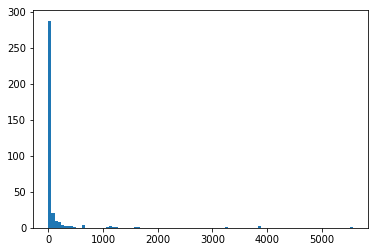

In [10]:
#How often are the codes used?

print("Average # of times a code is used: {:.2f}".format(df['Cost Code'].value_counts().mean()))
print("Median # of times a code is used: {:.2f}".format(df['Cost Code'].value_counts().median()))
print("{} is the most used code used {} times".format(df['Cost Code'].value_counts().idxmax(),df['Cost Code'].value_counts().max()))

plt.hist(df['Cost Code'].value_counts(), bins=100)
plt.show()

From this analysis we can see that the data is very unbalanced, with a small number of codes that have a very high usage, and most others with low usage. From this analysis we can tell that accuracy and recall would likely be poor metrics to evaluate the performance of the model, and precision or an F2-score weighted towards precision would be more valueable.

## Analysis of Numerical Fields
The Units, Unit Cost, and Cost fields are all numerical data related to the purchase order that intiutively may be related to the type of cost. I will start by exploring this data first.

In [11]:
#Describe the data, what kind of ranges are we dealing with for the relevant numerical fields?

df[['Units','Unit Cost','Cost']].describe()

,Units,Unit Cost,Cost
count,39303.000000,39303.000000,39303.000000
mean,27.093910,148.975775,1373.549263
std,641.505044,1897.340738,6928.548043
min,-30000.000000,-8483.230000,-22500.000000
25%,1.000000,2.035000,36.800000
50%,2.500000,9.470000,150.000000
75%,11.000000,63.000000,696.000000
max,102726.000000,300000.000000,639612.130000


From this description we see that there are negative values in each of the fields. These may be errors, but more likely they are credits back from the supplier where the company was overcharged for an item, and the supplier gave back some money.
In either case these records can be excluded from the dataset as they are not relevant to predicting the purchasing of new items.

In [12]:
#Update dataset to exclude rows with Units, Unit Cost, or Costs that are negative.
df = df[(df[['Units','Unit Cost','Cost']] >= 0).all(axis=1)]

df[['Units','Unit Cost','Cost']].describe()

,Units,Unit Cost,Cost
count,39141.000000,39141.000000,39141.000000
mean,27.998488,149.901813,1383.047704
std,624.646593,1900.609644,6939.240080
min,0.000000,0.000000,0.000000
25%,1.000000,2.150000,37.800000
50%,2.700000,9.800000,150.000000
75%,11.000000,64.000000,700.000000
max,102726.000000,300000.000000,639612.130000


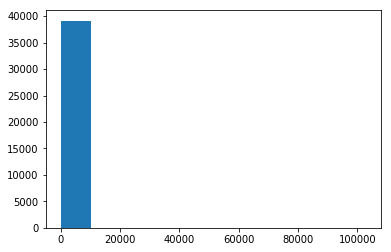

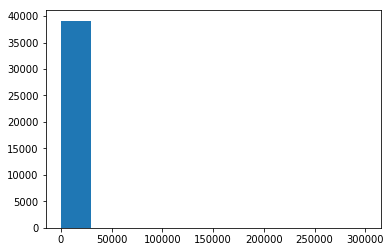

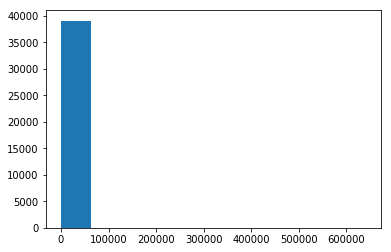

In [121]:
plt.hist(df['Units'], 10)
plt.show()
plt.hist(df['Unit Cost'], 10)
plt.show()
plt.hist(df['Cost'], 10)
plt.show()

Based on the percentiles and the histogram, we can clearly see that there are a very small number of high valued rows that are skewing the dataset highly. These are outliers that can be excluded from the data. So we will decrease the dataset to use only the 90th quartile for Costs, Units, and Unit Costs to get a more accurate representation of reality.

284460


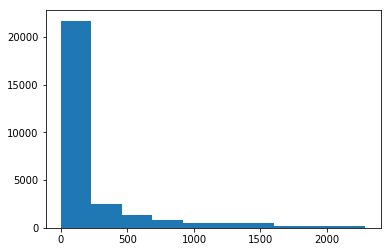

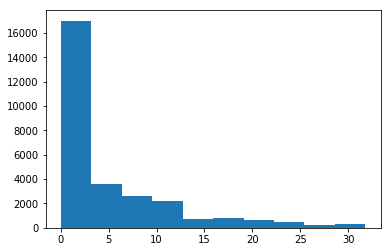

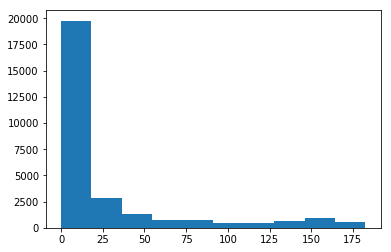

,Units,Unit Cost,Cost
count,28446.000000,28446.000000,28446.000000
mean,4.809546,26.707127,229.926338
std,6.528135,43.822091,388.835225
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,24.000000
50%,2.000000,8.000000,75.000000
75%,7.500000,25.500000,210.000000
max,31.800000,182.500000,2287.800000


In [13]:
#Create a new dataframe that takes only the 90th quartile of data from the 3 numerical columns.
df_90 = df[df['Cost'] < df['Cost'].quantile(.90)]
df_90 = df_90[df_90['Units'] < df_90['Units'].quantile(.90)]
df_90 = df_90[df_90['Unit Cost'] < df_90['Unit Cost'].quantile(.90)]


print(df_90.size)


plt.hist(df_90['Cost'], 10)
plt.show()

plt.hist(df_90['Units'], 10)
plt.show()

plt.hist(df_90['Unit Cost'], 10)
plt.show()

df_90[['Units','Unit Cost','Cost']].describe()

Average # of times a code is used: 97.42
Median # of times a code is used: 5.50
03-31-43 is the most used code used 4157 times


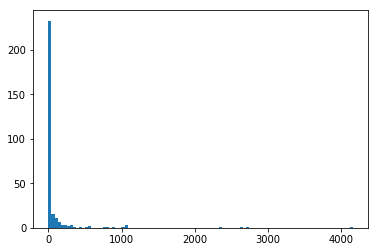

In [14]:
#looking at the cost code usage statistics again after cleaning up the records.

print("Average # of times a code is used: {:.2f}".format(df_90['Cost Code'].value_counts().mean()))
print("Median # of times a code is used: {:.2f}".format(df_90['Cost Code'].value_counts().median()))
print("{} is the most used code used {} times".format(df_90['Cost Code'].value_counts().idxmax(),df_90['Cost Code'].value_counts().max()))

plt.hist(df_90['Cost Code'].value_counts(), bins=100)
plt.show()

In [15]:
#Write the dataframe to a CSV file
df_90.to_csv(r'clean_data/Clean_PO_Dataset.csv', index=False)

## Analysis of Text Fields

The Vendor and Item Description are text fields that would also have a relationship with what cost code the item might belong to.
For example, if the vendor is "Joe's Windows' and the product description has the word "Windows" in it, it is likely that the cost code for this item will be one of the Glazing/Window cost codes.

## Benchmark Model

In [16]:

#True positive - if the model always picks the most used cost code
TP = df_90['Cost Code'].value_counts().max()

# True negative is 0 since we never predict a negative
TN = 0

# False positive = total predictions - true positives
FP = int((df_90['Cost Code'].size)) - TP

# False negative is 0 since we never predict a negative
FN = 0

accuracy = (TP + TN) / (TP + FP + FN + TN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1score = 2 * (precision * recall)/(precision + recall)
beta = 0.5
fbeta = (1+beta**2) * ((precision*recall)/((beta**2 * precision) + recall))
print('Benchmark model Accuracy: {:.2f}  Precision: {:.2f}  Recall: {:.2f}  f1-score: {:.2f}  fbeta-score: {:.2f}'.format(accuracy, precision, recall, f1score, fbeta))




Benchmark model Accuracy: 0.15  Precision: 0.15  Recall: 1.00  f1-score: 0.26  fbeta-score: 0.18
